In [19]:
import sys
sys.path.append("../src")

from preprocessing import *
from feature_extraction import *
from generate_heatmap import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

In [20]:
volunteer_ids = [f"S{n:03d}" for n in range(1,110)]
channel_ids = ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 
               'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 
               'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 
               'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 
               'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 
               'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 
               'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 
               'Oz', 'O2', 'Iz']
root_dir = '../data/files/'
result_dir = '../results/tmp/'

In [21]:
for v in volunteer_ids:
    r1, r2 = extract_data(v, root_dir)
    r1, r2 = filter_data(r1, r2)

    data_filtered = etc_with_no_order(r1, r2, v, channel_ids)

In [22]:
plot_heatmap(data_filtered, result_dir)

FileNotFoundError: [Errno 2] No such file or directory: ''

In [4]:
for v in volunteer_ids:
    r1, r2 = extract_data(v, root_dir)

    data_unfiltered = etc_with_no_order(r1, r2, v, channel_ids)

In [11]:
data_filtered['delta'] = data_filtered['ETC_EyesOpen'] - data_filtered['ETC_EyesClosed']
avg_delta_filtered = data_filtered.groupby('channel')['delta'].mean()

In [6]:
data_unfiltered['delta'] = data_unfiltered['ETC_EyesOpen'] - data_unfiltered['ETC_EyesClosed']
avg_delta_unfiltered = data_unfiltered.groupby('channel')['delta'].mean()

In [7]:
electrode_coords = {
    "Fp1.": (4,9), "Fpz.": (5,9), "Fp2.": (6,9),
    "Af7.": (1,8), "Af3.": (3,8), "Afz.": (5,8), "Af4.": (7,8), "Af8.": (9,8), 
    "F7..": (1,7), "F5..": (2,7), "F3..": (3,7), "F1..": (4,7), "Fz..": (5,7), "F2..": (6,7), "F4..": (7,7), "F6..": (8,7), "F8..": (9,7),
    "Ft7.": (1,6), "Fc5.": (2,6), "Fc3.": (3,6), "Fc1.": (4,6), "Fcz.": (5,6), "Fc2.": (6,6), "Fc4.": (7,6), "Fc6.": (8,6), "Ft8.": (9,6),
    "T9..": (0,5), "T7..": (1,5), "C5..": (2,5), "C3..": (3,5), "C1..": (4,5), "Cz..": (5,5), "C2..": (6,5), "C4..": (7,5), "C6..": (8,5), "T8..": (9,5), "T10.": (10,5),
    "Tp7.": (1,4), "Cp5.": (2,4), "Cp3.": (3,4), "Cp1.": (4,4), "Cpz.": (5,4), "Cp2.": (6,4), "Cp4.": (7,4), "Cp6.": (8,4), "Tp8.": (9,4),
    "P7..": (1,3), "P5..": (2,3), "P3..": (3,3), "P1..": (4,3), "Pz..": (5,3), "P2..": (6,3), "P4..": (7,3), "P6..": (8,3), "P8..": (9,3),
    "Po7.": (1,2), "Po3.": (3,2), "Poz.": (5,2), "Po4.": (7,2), "Po8.": (9,2),
    "O1..": (4,1), "Oz..": (5,1), "O2..": (6,1),
    "Iz..": (5,0)
}

# Clean channel names
new_coords = {}
for ch in list(electrode_coords.keys()):
    v = electrode_coords[ch]
    clean_ch = ch.strip('.')
    if 'Fp' not in clean_ch:
        clean_ch = clean_ch.upper()
    if clean_ch.endswith('Z'):
        clean_ch = clean_ch[:-1] + 'z'
    new_coords[clean_ch] = v

electrode_coords = new_coords

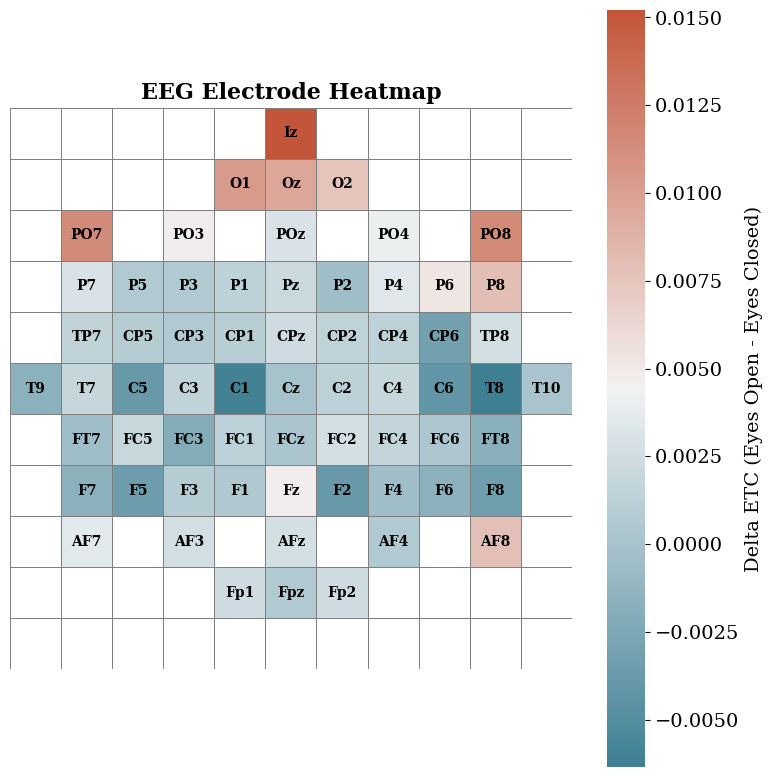

In [13]:
# Create heatmap grid
heatmap = np.full((11, 11), np.nan)
for ch, delta_val in avg_delta_filtered.items():
    if ch in electrode_coords:
        x, y = electrode_coords[ch]
        heatmap[y, x] = delta_val

# Set global font to Times New Roman
plt.rcParams.update({
    "font.family": "serif",
#    "font.serif": "Times New Roman",
#    "font.size": 14 
})

# Plot heatmap
fig, ax = plt.subplots(figsize=(8,8))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(
    heatmap, 
    cmap=cmap, 
    square=True, 
    linewidths=0.5, 
    linecolor='gray',
    cbar_kws={'label': 'Delta ETC (Eyes Open - Eyes Closed)'},
    mask=np.isnan(heatmap), 
    ax=ax
)

# Annotate electrodes
for ch, (x, y) in electrode_coords.items():
    if heatmap[y, x] is not np.nan:
        ax.text(
            x + 0.5, y + 0.5, ch, 
            ha='center', va='center',
            fontsize=10, color='black', weight='bold'
        )

# Final adjustments
ax.set_title("EEG Electrode Heatmap", fontsize=16, weight='bold')
ax.axis('off')  # Remove axis ticks and labels
plt.tight_layout()

# Save high-resolution figure
plt.savefig("electrode_heatmap_filtered.png", dpi=300)
plt.show()

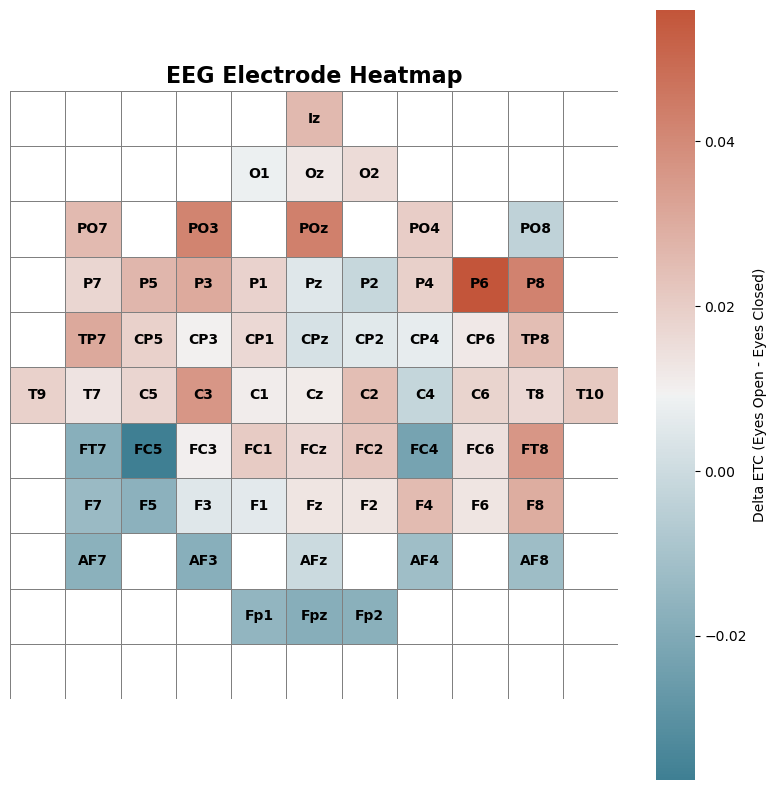

In [9]:
# Create heatmap grid
heatmap = np.full((11, 11), np.nan)
for ch, delta_val in avg_delta_unfiltered.items():
    if ch in electrode_coords:
        x, y = electrode_coords[ch]
        heatmap[y, x] = delta_val

# Plot heatmap
fig, ax = plt.subplots(figsize=(8,8))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(
    heatmap, 
    cmap=cmap, 
    square=True, 
    linewidths=0.5, 
    linecolor='gray',
    cbar_kws={'label': 'Delta ETC (Eyes Open - Eyes Closed)'},
    mask=np.isnan(heatmap), 
    ax=ax
)

# Annotate electrodes
for ch, (x, y) in electrode_coords.items():
    if heatmap[y, x] is not np.nan:
        ax.text(
            x + 0.5, y + 0.5, ch, 
            ha='center', va='center',
            fontsize=10, color='black', weight='bold'
        )

# Final adjustments
ax.set_title("EEG Electrode Heatmap", fontsize=16, weight='bold')
ax.axis('off')  # Remove axis ticks and labels
plt.tight_layout()

# Save high-resolution figure
plt.savefig("electrode_heatmap_unfiltered.png", dpi=300)
plt.show()